## Installing uv

To start, you'll want to have uv installed:

https://docs.astral.sh/uv/getting-started/installation/


**Next, run this in the terminal, from the parent directory:**

    uv sync


Now you will have the kernel used to run this notebook

---

## Running the Required Servers

You need to run **three servers**, each in its own terminal:

- `central_server.py`
- `AS_server_AtomBlastTwin.py`
- `Ceos_server_twin.py`

### 1. Activate the Virtual Environment

`uv` should have created a `.venv` directory for you.

**On macOS / Linux:**

    source .venv/bin/activate

**On Windows (likely):**

    source .venv/Scripts/activate

You should now see the environment activated.

---

### 2. Start the Servers

**Terminal 1 — Central Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.protocols.central_server

**Terminal 2 — Atom Resolution Simulation Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.AS_server_AtomBlastTwin

**Terminal 3 — CEOS Twin Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.Ceos_server_twin

---

You're now ready to run this notebook! 🚀

In [1]:
import sys
import ast
import numpy as np
sys.path.insert(0, '../')
from asyncroscopy.clients.notebook_client import NotebookClient
from asyncroscopy.utils import parula_color_map
import matplotlib.pyplot as plt

import pyTEMlib
from pyTEMlib import probe_tools as pt
%matplotlib ipympl

### Connections:

In [2]:
# Connect the Client to the central (async) server
tem = NotebookClient.connect(host='localhost',port=9000)

# Tell the central server address of all connected instruments
routing_table= {"AS": ("localhost", 9001),
                "Gatan": ("localhost", 9002),
                "Ceos": ("localhost", 9003),
                "Preacquired_AS": ("localhost", 9004)}
tem.send_command('Central',"set_routing_table", routing_table)

# ConnectionResetError: [Errno 54] Connection reset by peer 
# in terminal, type:
# lsof -i :9000
# then kill PIDs on that port


Connecting to central server localhost:9000...
Connected to central server.


'[Central] Routing table updated'

In [3]:
# connect to the AutoScript computer and initialize microscope
tem.send_command('AS',command='connect_AS',args={'host':'localhost','port':9001})
tem.send_command(destination = 'Ceos', command = 'getInfo', args = {})

'CEOS Digital Twin Server'

### Help commands:

In [4]:
# Now that we're routed to all instruments,
# let's take an inventory of commands available on each instrument
cmds = tem.send_command('AS', 'discover_commands')
print(cmds)

["blank_beam", "connect_AS", "connectionLost", "connectionMade", "dataReceived", "disconnect", "discover_commands", "get_atom_count", "get_dose_map", "get_help", "get_scanned_image", "get_stage", "get_status", "lengthLimitExceeded", "load_sample", "logPrefix", "makeConnection", "pauseProducing", "place_beam", "reset_sample", "resumeProducing", "sendString", "set_beam_current", "set_fov", "stopProducing", "stringReceived", "unblank_beam"]


### Setting the aberrations from known values:

In [5]:
aberrations = pt.get_target_aberrations("Spectra300", 200000)
aberrations['C23a'] = 10
aberrations['C23b'] = 10
tem.send_command(destination = 'Ceos', command = 'uploadAberrations', args = aberrations)
pt.print_aberrations(aberrations)

In [6]:
tem.send_command('AS', 'load_sample')


'Loaded sample with 3600 atoms. Dose map initialized.'

### Get an image:

simulated with pystemsim inside the AS_server_SimAtomRes (working with the Ceos server)

'Current atom count: 3600'

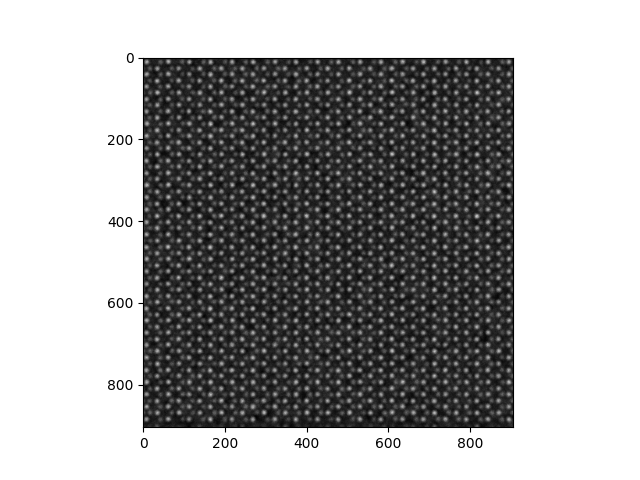

In [7]:
image_args = {'scanning_detector':'HAADF',
                'size':512,
                'dwell_time':10e-6}

beam_current = 1
tem.send_command('AS', 'set_beam_current', {'current':beam_current}) # pA
img = tem.send_command('AS','get_scanned_image', image_args)

plt.figure()
plt.imshow(img, cmap="gray")
tem.send_command('AS', 'get_atom_count', {})

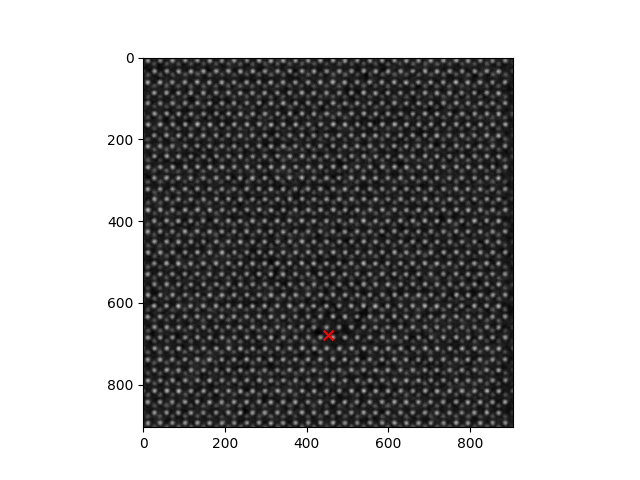

In [8]:
# Position beam and expose
beam_pos = [0.75, 0.5]

beam_current = 10000
tem.send_command('AS', 'place_beam', {'x': beam_pos[1], 'y': beam_pos[0]})
tem.send_command('AS', 'set_beam_current', {'current': beam_current})
tem.send_command('AS', 'unblank_beam', {'duration': 10}) # seconds

beam_current = 1
tem.send_command('AS', 'set_beam_current', {'current':beam_current}) # pA
img = tem.send_command('AS','get_scanned_image', image_args)

plt.figure()
plt.imshow(img.T, cmap="gray")
plt.scatter(beam_pos[1] * img.shape[1], beam_pos[0] * img.shape[0], color='red', s=50, marker='x')


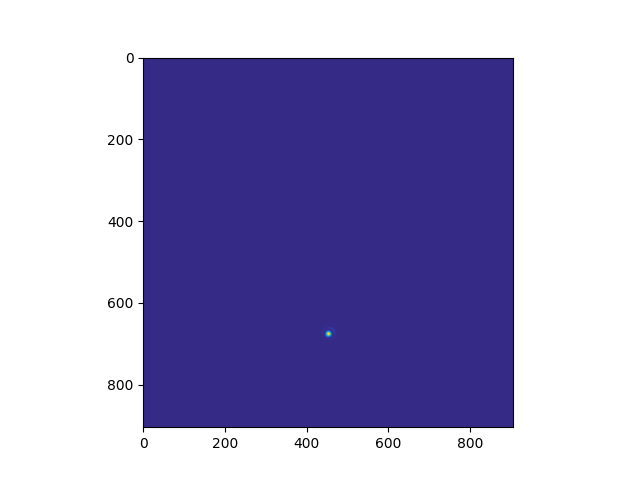

In [9]:
dose_map = tem.send_command('AS', 'get_dose_map', {})

plt.figure()
plt.imshow(dose_map, cmap=parula_color_map)

In [10]:
tem.send_command(destination = 'Ceos', command = 'correctAberration', args = {"name": 'C10', "value": -5})

'Aberration C10 changed to -5.0'

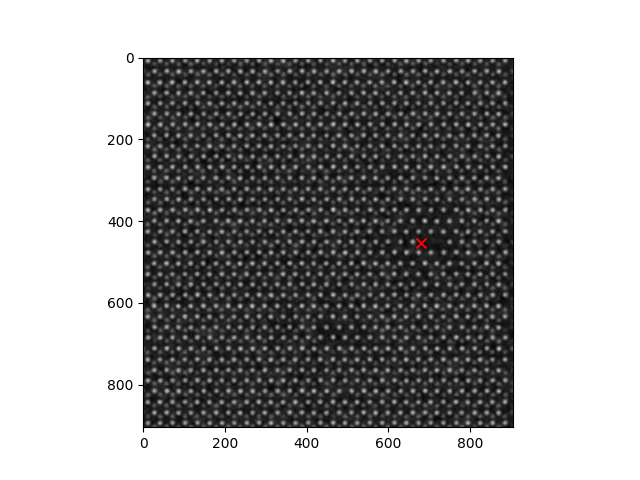

In [11]:
# Position beam and expose
beam_pos = [0.5, 0.75]

beam_current = 10000
tem.send_command('AS', 'place_beam', {'x': beam_pos[1], 'y': beam_pos[0]})
tem.send_command('AS', 'set_beam_current', {'current': beam_current})
tem.send_command('AS', 'unblank_beam', {'duration': 100}) # seconds

beam_current = 1
tem.send_command('AS', 'set_beam_current', {'current':beam_current}) # pA
tem.send_command(destination = 'Ceos', command = 'correctAberration', args = {"name": 'C10', "value": 0})
img = tem.send_command('AS','get_scanned_image', image_args)

plt.figure()
plt.imshow(img.T, cmap="gray")
plt.scatter(beam_pos[1] * img.shape[1], beam_pos[0] * img.shape[0], color='red', s=50, marker='x')


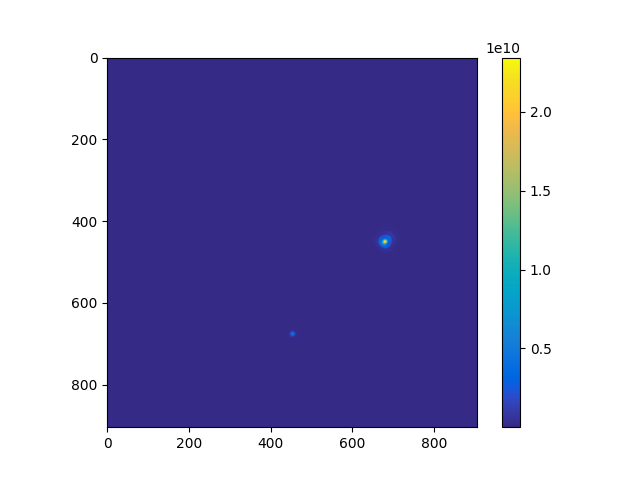

In [12]:
dose_map = tem.send_command('AS', 'get_dose_map', {})

plt.figure()
plt.imshow(dose_map, cmap=parula_color_map)
plt.colorbar()
